In [72]:
# Import required package
using DifferentialEquations
using COBREXA
using DataFrames
using Tulip
using Plots
using Colors
using ModelingToolkit
using Statistics
using GLM
using Random
using Flux
using ProgressMeter
using MLBase #Confusion matrix function
using Serialization
using TreeParzen
using CSV
using LatinHypercubeSampling
using ColorSchemes

println("Imports completed")

Imports completed


In [87]:
#Read in saved models
home_path = "C:/Users/Charlotte/OneDrive - University of Edinburgh/Documents/research/joint-simulator/"
feas_model = deserialize(home_path * "beta_carotene/ml_models/feas_model.jls")
lam_model = deserialize(home_path * "beta_carotene/ml_models/lam_model.jls")
v_in_model = deserialize(home_path * "beta_carotene/ml_models/v_in_model.jls")
v_fpp_model = deserialize(home_path * "beta_carotene/ml_models/v_fpp_model.jls")
v_ipp_model = deserialize(home_path * "beta_carotene/ml_models/v_ipp_model.jls")
println("All models read in successfully!")

All models read in successfully!


In [89]:
michaelismenten(x, kcat, km) = (kcat*x)/(km+x)
michaelismenten_dual(x, y, kcat, km1, km2) = (kcat*((x*y)/(km1*km2)))/(1+(x/km1)+(y/km2))

function bc_params(param_name)
    params = Dict("kcat_crtE" => 0.2456 * 60 * 60, #[1/s] DL,
    "kcat_crtB" => 0.066 * 60 * 60, #[1/s -> 1/hr] DL
    "kcat_crtI" => 4.2255 * 60 * 60, #[1/s] DL
    "kcat_crtY" => 42.9099 * 60 * 60, #[1/s] DL
    "km_crtE_fpp" => 0.0321, #[mM] Brenda
    "km_crtE_ipp" => 0.0234, #[mM] Brenda
    "km_crtB" => 0.01682, #[mM] Brenda
    "km_crtI" => 9.179, #[mM] Brenda
    "km_crtY" => 0.035, #[mM] Brenda
    )
    return params[param_name]
end

function beta_carotene(du, u, p, t)
    lam, v_in, v_fpp, v_ipp, W = p
    fpp, ipp, ggp, phy, lyc, bcar, crtE, crtB, crtI, crtY = u
    k_crtE, k_crtB, k_crtI, k_crtY = W
    v_crtE = crtE * michaelismenten_dual(fpp, ipp, bc_params("kcat_crtE"), bc_params("km_crtE_fpp"), bc_params("km_crtE_ipp"))
    v_crtB = crtB * michaelismenten(ggp, bc_params("kcat_crtB"), bc_params("km_crtB"))
    v_crtI = crtI * michaelismenten(phy, bc_params("kcat_crtI"), bc_params("km_crtI"))
    v_crtY = crtY * michaelismenten(lyc, bc_params("kcat_crtY"), bc_params("km_crtY"))

    du[1] = -v_fpp - lam*fpp #fpp
    du[2] = - v_ipp - v_fpp + v_in - 2*v_crtE - lam*ipp #ipp
    du[3] = v_crtE - v_crtB - lam*ggp #ggp
    du[4] = v_crtB - v_crtI - lam*phy #phy
    du[5] = v_crtI - v_crtY - lam*lyc #lyc
    du[6] = v_crtY - lam*bcar #bcar
    du[7] = k_crtE - lam*crtE #crtE
    du[8] = k_crtB - lam*crtB #crtB
    du[9] = k_crtI - lam*crtI #crtI
    du[10] = k_crtY - lam*crtY #crtY
end

function fba_loop(N, W, u0, warmup_flag=0)
    #instantiate initial times
    deltat = 1/(60*60) #genetic timescale, seconds
    starttime = 0.
    endtime = starttime + deltat
    tspan = [starttime, endtime]
    savetimes = [starttime, endtime] #saving start time and end times for alternate v_p calculation

    fba_df = DataFrame("v_p" => [0.0])
    lam = predict(lam_model, fba_df)[1]
    v_in =  predict(v_in_model, fba_df)[1]
    v_fpp =  predict(v_fpp_model, fba_df)[1]
    v_ipp = predict(v_ipp_model, fba_df)[1]
    
    p = [lam, v_in, v_fpp, v_ipp, W] 

    #FBA-ODE optimization loop
    ode_data = DataFrame("time" => [0], "fpp" => u0[1], "ipp" => u0[2], "ggp" => u0[3], "phy" => u0[4], "lyc" => u0[5], "bcar" => u0[6], "crtE" => u0[7], "crtB" => u0[8], "crtI" => u0[9], "crtY" => u0[10], "v_p" => [0], "feas" => [1])
    fba_data = DataFrame("time" => [0], "v_in" => [v_in], "v_fpp" => [v_fpp], "v_ipp" => [v_ipp], "lam" => [lam]);

    #println("Beginning loop...")
    for i in 1:N
        #println("Iteration ", i)
        prob = ODEProblem(beta_carotene, u0, tspan, p)
        #Solve ODE
        sol = solve(prob, Rosenbrock23(), reltol=1e-3, abstol=1e-6, saveat=savetimes)

        #Solve for pathway fluxes from final concentrations
        v_p = sol.u[end][7] * michaelismenten_dual(sol.u[end][1], sol.u[end][2], bc_params("kcat_crtE"), bc_params("km_crtE_fpp"), bc_params("km_crtE_ipp"))
    
        #Predict if FBA reaction is feasible using ML model
        flux_data = DataFrame("v_p" => [v_p])
        feas = predict(feas_model, flux_data)
        feas_class = ifelse.(feas .> 0.5, 1, 0)[1]

        if feas_class == 0 && warmup_flag == 1
            break
        end
        
        ode_data = vcat(ode_data, DataFrame("time" => sol.t[1], "fpp" => sol.u[1][1], "ipp" => sol.u[1][2], "ggp" => sol.u[1][3], "phy" => sol.u[1][4], "lyc" => sol.u[1][5], "bcar" => sol.u[1][6], "crtE" => sol.u[1][7], "crtB" => sol.u[1][8], "crtI" => sol.u[1][9], "crtY" => sol.u[1][10], "v_p" => v_p, "feas" => [feas_class]))
        
        flux_data = DataFrame("v_p" => [v_p])
        #Predict new v_in, lam using ML model
        lam = predict(lam_model, flux_data)[1]
        v_in = predict(v_in_model, flux_data)[1]
        v_fpp =  predict(v_fpp_model, flux_data)[1]
        v_ipp = predict(v_ipp_model, flux_data)[1]

        p = [lam, v_in, v_fpp, v_ipp, p[5]] 

        starttime = endtime
        endtime = starttime + deltat
        tspan = [starttime, endtime]
        savetimes = [starttime, endtime]

        u0 = sol.u[end]
        #Save FBA data
        fba_data = vcat(fba_data, DataFrame("time" => [starttime], "v_in" => [p[2]], "v_fpp" => [p[3]], "v_ipp" => [p[4]], "lam" => [p[1]]))
    end
    return ode_data, fba_data
end

fba_loop (generic function with 2 methods)

In [97]:
W = [1.38505205e-06, 2.24022339e-06, 1.97856795e-05, 2.81003547e-04]
N = 10000
u0 = [0.7, 0.7, 0., 0., 0., 0., 0., 0., 0., 0.]

ode_data, fba_data = fba_loop(N, W, u0, 1)

(10001×13 DataFrame
   Row │ time         fpp       ipp       ggp          phy          lyc        ⋯
       │ Float64      Float64   Float64   Float64      Float64      Float64    ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ 0.0          0.7       0.7       0.0          0.0          0.0        ⋯
     2 │ 0.0          0.7       0.7       0.0          0.0          0.0
     3 │ 0.000277778  0.699873  0.699874  5.84447e-10  2.08999e-19  0.0
     4 │ 0.000555556  0.699747  0.699748  2.33722e-9   5.28847e-18  7.93829e-2
     5 │ 0.000833333  0.69962   0.699622  5.25746e-9   2.80691e-17  1.0353e-25 ⋯
     6 │ 0.00111111   0.699494  0.699497  9.34433e-9   8.99204e-17  6.00598e-2
     7 │ 0.00138889   0.699367  0.699371  1.4597e-8    2.20737e-16  2.31679e-2
     8 │ 0.00166667   0.699241  0.699245  2.10145e-8   4.58928e-16  6.95045e-2
   ⋮   │      ⋮          ⋮         ⋮           ⋮            ⋮            ⋮     ⋱
  9995 │ 2.77583      0.115694  0.

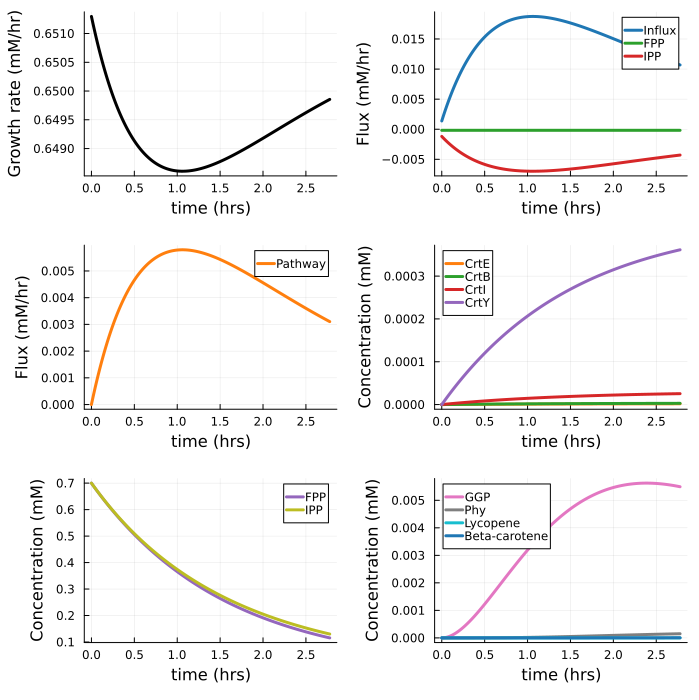

In [98]:
palette= ColorSchemes.tab10.colors
p1 = plot(fba_data.time, fba_data.lam, lw=3, legend=false, color="black", xlabel="time (hrs)", ylabel="Growth rate (mM/hr)")
p2 = plot(fba_data.time, [fba_data.v_in fba_data.v_fpp fba_data.v_ipp],  label=["Influx" "FPP" "IPP"], color=[palette[1] palette[3] palette[4]], lw=3,xlabel="time (hrs)", ylabel="Flux (mM/hr)")
p3 = plot(ode_data.time, ode_data.v_p,lw=3, label="Pathway", color=palette[2], xlabel="time (hrs)", ylabel="Flux (mM/hr)")
p4 = plot(ode_data.time, [ode_data.crtE ode_data.crtB ode_data.crtI ode_data.crtY],lw=3,label=["CrtE" "CrtB" "CrtI" "CrtY"], color=[palette[2] palette[3] palette[4] palette[5]], xlabel="time (hrs)", ylabel="Concentration (mM)")
p5 = plot(ode_data.time, [ode_data.fpp ode_data.ipp], lw=3, label=["FPP" "IPP"], color=[palette[5] palette[9]], xlabel="time (hrs)", ylabel="Concentration (mM)")
p6 = plot(ode_data.time, [ode_data.ggp ode_data.phy ode_data.lyc ode_data.bcar], lw=3, label=["GGP" "Phy" "Lycopene" "Beta-carotene"], color=[palette[7] palette[8] palette[10] palette[1]], xlabel="time (hrs)", ylabel="Concentration (mM)")

plot(p1, p2, p3, p4, p5, p6, layout=(3,2), size=(700, 700))

In [ ]:
#Random K sampling with appropriate priors

